### TSUNAMI

In [1]:
import numpy as np
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized #, acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
from numpy.random import random, seed

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
from fireworks.nbodylib.timesteps import adaptive_timestep_simple, adaptive_timestep_r
from fireworks.nbodylib.integrators import integrator_tsunami

In [3]:
seed(42)

In [4]:
mass1 = 1.
mass2 = 2.
rp = 5. 
e_1 = 0.5               
e_2 = 0.9
e_3 = 0.99

part_1 = ic_two_body(mass1, mass2, rp, e_1)
part_2 = ic_two_body(mass1, mass2, rp, e_2)
part_3 = ic_two_body(mass1, mass2, rp, e_3)

M_tot_1 = np.sum(part_1.mass)
M_tot_2 = np.sum(part_2.mass)
M_tot_3 = np.sum(part_3.mass)

# e = 0.5 
a_1 = rp / (1 - e_1)
P_1 = np.sqrt((4 * np.pi**2. * a_1**3.)/(M_tot_1))
print('P_1 = ', P_1)

# e = 0.9
a_2 = rp / (1 - e_2)
P_2 = np.sqrt((4 * np.pi**2. * a_2**3.)/(M_tot_2))
print('P_2 = ', P_2)

# e = 0.99 
a_3 = rp / (1 - e_3)
P_3 = np.sqrt((4 * np.pi**2. * a_3**3.)/(M_tot_3))
print('P_3 = ', P_3)

P_1 =  114.71474419090953
P_2 =  1282.5498301618645
P_3 =  40557.78675973606


In [5]:
N = 2                       # number of particles
nsteps = 100000            #arbitrary number of timesteps
t = 0
tsimulation_1 = 10*P_1      # end of the simulation for e = 0.5
tsimulation_2 = 10*P_2      # end of the simulation for e = 0.9
tsimulation_3 = 10*P_3      # end of the simulation for e = 0.99
h_1 = (tsimulation_1-t)/nsteps
h_2 = (tsimulation_2-t)/nsteps
h_3 = (tsimulation_3-t)/nsteps
#h_1 = 1
#h_2 = 10
#h_3 = 100
print(h_1, h_2, h_3)    

0.011471474419090954 0.12825498301618646 4.055778675973606


### EULER

In [6]:
part_1_euler_adaptive = part_1.copy()
part_2_euler_adaptive = part_2.copy()
part_3_euler_adaptive = part_3.copy()

In [7]:
r  = part_1_euler_adaptive.radius()
v  = part_1_euler_adaptive.vel_mod()
ts = r/v
ts =  np.nanmin(ts[np.nonzero(ts)])
print(r)
print(v)
print(ts)

[[0.]
 [5.]]
[[0.63245553]
 [0.31622777]]
15.811388300841896


In [8]:
def integration_euler_adaptive(part, h, tsimulation, t, N):
    path_1 = []
    path_2 = []
    time   = []
    time2  = []
    Etot_euler = []
    Ekin_euler = []
    Epot_euler = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_euler(part, h, acceleration_direct_vectorized)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_euler.append(Etot_n)
            Ekin_euler.append(Ekin_n)
            Epot_euler.append(Epot_n)
        
        ts_1, _, _ = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    time   = np.array(time)
    time2  = np.array(time2)
    Etot_euler = np.array(Etot_euler)
    Ekin_euler = np.array(Ekin_euler)
    Etot_euler = np.array(Epot_euler)

    return path_1, path_2, Etot_euler, Ekin_euler, Epot_euler, time, time2


In [9]:
# e = 0.5
path1_euler_1_adaptive, path2_euler_1_adaptive, Etot_euler_1_adaptive, Ekin_euler_1_adaptive, Epot_euler_1_adaptive, time_euler_1_adaptive, time2_euler_1_adaptive = integration_euler_adaptive(part_1_euler_adaptive,
                                                                                                                                                                                                h_1, tsimulation_1, 
                                                                                                                                                                                                t, 
                                                                                                                                                                                                N)


# e = 0.9
path1_euler_2_adaptive, path2_euler_2_adaptive, Etot_euler_2_adaptive, Ekin_euler_2_adaptive, Epot_euler_2_adaptive, time_euler_2_adaptive, time2_euler_2_adaptive = integration_euler_adaptive(part_2_euler_adaptive,
                                                                                                                                                                                                h_2, tsimulation_2, 
                                                                                                                                                                                                t, 
                                                                                                                                                                                                N)


# e = 0.99
path1_euler_3_adaptive, path2_euler_3_adaptive, Etot_euler_3_adaptive, Ekin_euler_3_adaptive, Epot_euler_3_adaptive, time_euler_3_adaptive, time2_euler_3_adaptive = integration_euler_adaptive(part_3_euler_adaptive,
                                                                                                                                                                                                h_3, tsimulation_3, 
                                                                                                                                                                                                t, 
                                                                                                                                                                                                N)



/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/nbodylib/dynamics.py:188: RuntimeWarning: invalid value encountered in divide


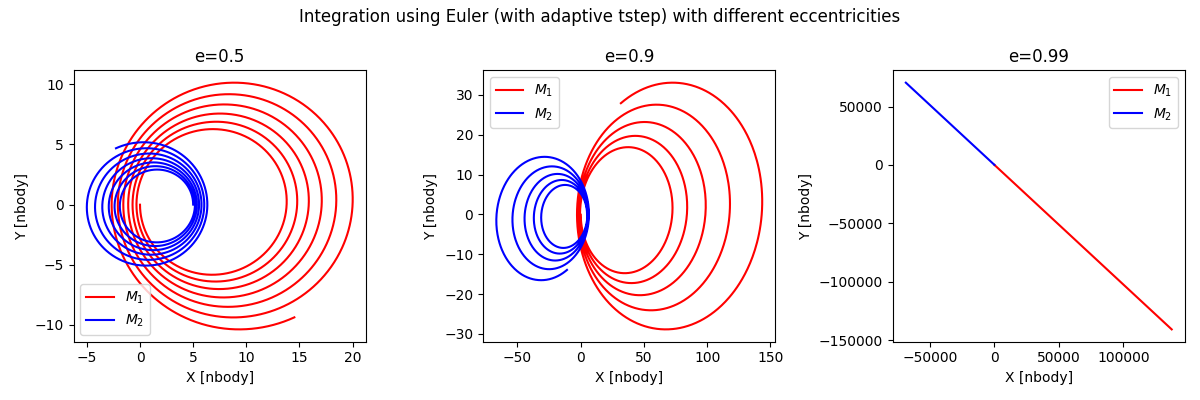

In [10]:
plt.figure(figsize=(12,4))

plt.suptitle('Integration using Euler (with adaptive tstep) with different eccentricities')

#e=0.5
plt.subplot(1,3,1)
plt.title('e=0.5')
plt.plot(path1_euler_1_adaptive[:,0], path1_euler_1_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_euler_1_adaptive[:,0], path2_euler_1_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.9 
plt.subplot(1,3,2)
plt.title('e=0.9')
plt.plot(path1_euler_2_adaptive[:,0], path1_euler_2_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_euler_2_adaptive[:,0], path2_euler_2_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.99
plt.subplot(1,3,3)
plt.title('e=0.99')
plt.plot(path1_euler_3_adaptive[:,0], path1_euler_3_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_euler_3_adaptive[:,0], path2_euler_3_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

plt.tight_layout()

### LEAPFROG

In [11]:
part_1_leapfrog_adaptive = part_1.copy()
part_2_leapfrog_adaptive = part_2.copy()
part_3_leapfrog_adaptive = part_3.copy()

In [12]:
def integration_leapfrog_adaptive(part, h, tsimulation, t, N):
    path_1 = []
    path_2 = []
    time   = []
    time2  = []
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_leapfrog(part, h, acceleration_direct_vectorized)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_leapfrog.append(Etot_n)
            Ekin_leapfrog.append(Ekin_n)
            Epot_leapfrog.append(Epot_n)
        
        ts_1, _, _ = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    time   = np.array(time)
    time2  = np.array(time2)
    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Etot_leapfrog = np.array(Epot_leapfrog)

    return path_1, path_2, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog, time, time2


In [13]:
# e = 0.5
path1_leapfrog_1_adaptive, path2_leapfrog_1_adaptive, Etot_leapfrog_1_adaptive, Ekin_leapfrog_1_adaptive, Epot_leapfrog_1_adaptive, time_leapfrog_1_adaptive, time2_leapfrog_1_adaptive = integration_leapfrog_adaptive(part_1_leapfrog_adaptive,
                                                                                                                                                                                                                        h_1, tsimulation_1, t, N)

# e = 0.9
path1_leapfrog_2_adaptive, path2_leapfrog_2_adaptive, Etot_leapfrog_2_adaptive, Ekin_leapfrog_2_adaptive, Epot_leapfrog_2_adaptive, time_leapfrog_2_adaptive, time2_leapfrog_2_adaptive = integration_leapfrog_adaptive(part_2_leapfrog_adaptive,
                                                                                                                                                                                                                        h_2, tsimulation_2, t, N)


# e = 0.99
path1_leapfrog_3_adaptive, path2_leapfrog_3_adaptive, Etot_leapfrog_3_adaptive, Ekin_leapfrog_3_adaptive, Epot_leapfrog_3_adaptive, time_leapfrog_3_adaptive, time2_leapfrog_3_adaptive = integration_leapfrog_adaptive(part_3_leapfrog_adaptive,
                                                                                                                                                                                                                        h_3, tsimulation_3, t, N)

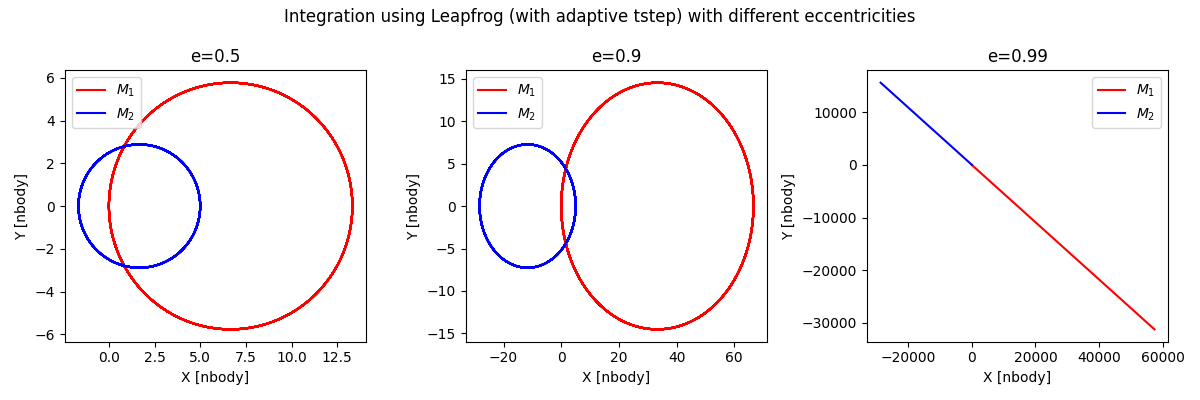

In [14]:
plt.figure(figsize=(12,4))

plt.suptitle('Integration using Leapfrog (with adaptive tstep) with different eccentricities')

#e=0.5
plt.subplot(1,3,1)
plt.title('e=0.5')
plt.plot(path1_leapfrog_1_adaptive[:,0], path1_leapfrog_1_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_leapfrog_1_adaptive[:,0], path2_leapfrog_1_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.9 
plt.subplot(1,3,2)
plt.title('e=0.9')
plt.plot(path1_leapfrog_2_adaptive[:,0], path1_leapfrog_2_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_leapfrog_2_adaptive[:,0], path2_leapfrog_2_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.99
plt.subplot(1,3,3)
plt.title('e=0.99')
plt.plot(path1_leapfrog_3_adaptive[:,0], path1_leapfrog_3_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_leapfrog_3_adaptive[:,0], path2_leapfrog_3_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

plt.tight_layout()

### RUNGE-KUTTA

In [15]:
part_1_rungekutta_adaptive = part_1.copy()
part_2_rungekutta_adaptive = part_2.copy()
part_3_rungekutta_adaptive = part_3.copy()

In [16]:
def integration_rungekutta_adaptive(part, h, tsimulation, t, N):
    path_1 = []
    path_2 = []
    time   = []
    time2  = []
    Etot_rungekutta = []
    Ekin_rungekutta = []
    Epot_rungekutta = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_rungekutta(part, h, acceleration_direct_vectorized)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_rungekutta.append(Etot_n)
            Ekin_rungekutta.append(Ekin_n)
            Epot_rungekutta.append(Epot_n)
        
        ts_1, _, _ = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    time   = np.array(time)
    time2  = np.array(time2)
    Etot_rungekutta = np.array(Etot_rungekutta)
    Ekin_rungekutta = np.array(Ekin_rungekutta)
    Etot_rungekutta = np.array(Epot_rungekutta)

    return path_1, path_2, Etot_rungekutta, Ekin_rungekutta, Epot_rungekutta, time, time2


In [17]:
# e = 0.5
path1_rungekutta_1_adaptive, path2_rungekutta_1_adaptive, Etot_rungekutta_1_adaptive, Ekin_rungekutta_1_adaptive, Epot_rungekutta_1_adaptive, time_rungekutta_1_adaptive, time2_rungekutta_1_adaptive = integration_rungekutta_adaptive(part_1_rungekutta_adaptive,
                                                                                                                                                                                                                                h_1, tsimulation_1, t, N)

# e = 0.9
path1_rungekutta_2_adaptive, path2_rungekutta_2_adaptive, Etot_rungekutta_2_adaptive, Ekin_rungekutta_2_adaptive, Epot_rungekutta_2_adaptive, time_rungekutta_2_adaptive, time2_rungekutta_2_adaptive = integration_rungekutta_adaptive(part_2_rungekutta_adaptive,
                                                                                                                                                                                                                                h_2, tsimulation_2, t, N)

# e = 0.99
path1_rungekutta_3_adaptive, path2_rungekutta_3_adaptive, Etot_rungekutta_3_adaptive, Ekin_rungekutta_3_adaptive, Epot_rungekutta_3_adaptive, time_rungekutta_3_adaptive, time2_rungekutta_3_adaptive = integration_rungekutta_adaptive(part_3_rungekutta_adaptive,
                                                                                                                                                                                                                                h_3, tsimulation_3, t, N)

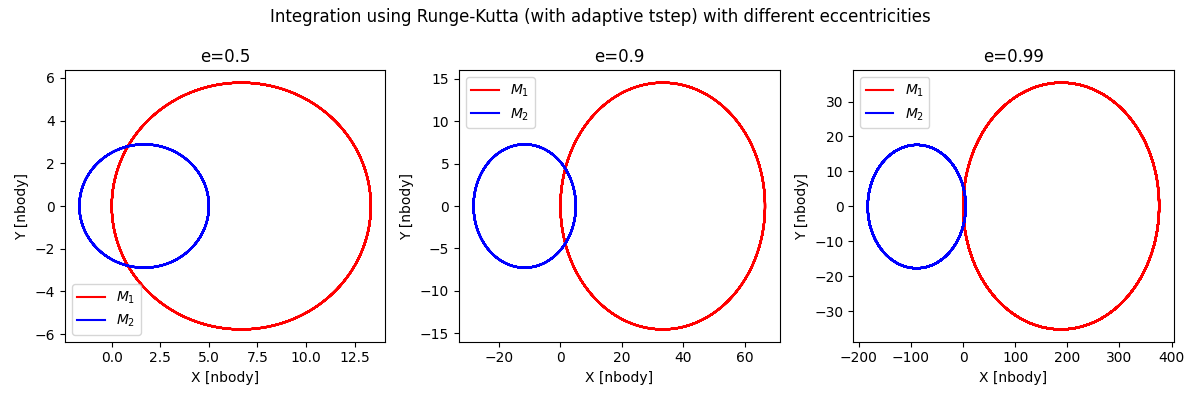

In [18]:
plt.figure(figsize=(12,4))

plt.suptitle('Integration using Runge-Kutta (with adaptive tstep) with different eccentricities')

#e=0.5
plt.subplot(1,3,1)
plt.title('e=0.5')
plt.plot(path1_rungekutta_1_adaptive[:,0], path1_rungekutta_1_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_rungekutta_1_adaptive[:,0], path2_rungekutta_1_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.9 
plt.subplot(1,3,2)
plt.title('e=0.9')
plt.plot(path1_rungekutta_2_adaptive[:,0], path1_rungekutta_2_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_rungekutta_2_adaptive[:,0], path2_rungekutta_2_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.99
plt.subplot(1,3,3)
plt.title('e=0.99')
plt.plot(path1_rungekutta_3_adaptive[:,0], path1_rungekutta_3_adaptive[:,1], label=f'$M_1$', color='red')
plt.plot(path2_rungekutta_3_adaptive[:,0], path2_rungekutta_3_adaptive[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

plt.tight_layout()

### TSUNAMI INTEGRATOR

In [19]:
part_1_tsunami = part_1.copy()
part_2_tsunami = part_2.copy()
part_3_tsunami = part_3.copy()

In [20]:
def integration_with_tsunami(part, tsimulation):
    tstart=0
    tintermediate = np.linspace(tstart, tsimulation, 100000)
    tcurrent=0
    pos1_tsu = []
    pos2_tsu = []

    for t in tintermediate:
        tstep=t-tcurrent
        if tstep <=0: continue 
        part_tsunami, efftime,_,_,_=integrator_tsunami(part, tstep)

        pos1_tsu.append(part_tsunami.pos[0].copy())
        pos2_tsu.append(part_tsunami.pos[1].copy())

        tcurrent=tcurrent+efftime

    pos1_tsu = np.array(pos1_tsu)
    pos2_tsu = np.array(pos2_tsu)

    return pos1_tsu, pos2_tsu



In [21]:
#e=0.5
pos1_tsu_1, pos2_tsu_1 = integration_with_tsunami(part_1_tsunami, tsimulation_1)

#e=0.9
pos1_tsu_2, pos2_tsu_2 = integration_with_tsunami(part_2_tsunami, tsimulation_2)

#e=0.99
pos1_tsu_3, pos2_tsu_3 = integration_with_tsunami(part_3_tsunami, tsimulation_3)

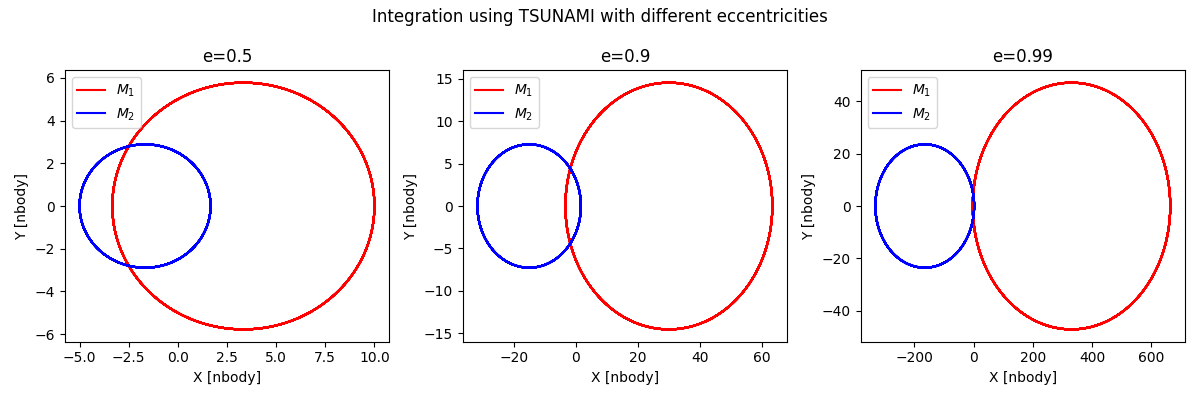

In [22]:
plt.figure(figsize=(12,4))

plt.suptitle('Integration using TSUNAMI with different eccentricities')

#e=0.5
plt.subplot(1,3,1)
plt.title('e=0.5')
plt.plot(pos1_tsu_1[:,0], pos1_tsu_1[:,1], label=f'$M_1$', color='red')
plt.plot(pos2_tsu_1[:,0], pos2_tsu_1[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.9
plt.subplot(1,3,2)
plt.title('e=0.9')
plt.plot(pos1_tsu_2[:,0], pos1_tsu_2[:,1], label=f'$M_1$', color='red')
plt.plot(pos2_tsu_2[:,0], pos2_tsu_2[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

#e=0.99
plt.subplot(1,3,3)
plt.title('e=0.99')
plt.plot(pos1_tsu_3[:,0], pos1_tsu_3[:,1], label=f'$M_1$', color='red')
plt.plot(pos2_tsu_3[:,0], pos2_tsu_3[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

plt.tight_layout()